In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data

In [3]:
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)

def period(p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


### conso.csv créé par pi4 node-red onglet Linky

In [4]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935238 entries, 0 to 1935237
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 29.5 MB


In [5]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1935233    0.21
1935234    0.21
1935235    0.21
1935236    0.20
1935237    0.15
Name: kWh, Length: 1935238, dtype: float64

In [6]:
conso_data['kWh']

0          0.16
1          0.16
2          0.16
3          0.16
4          0.16
           ... 
1935233    0.21
1935234    0.21
1935235    0.21
1935236    0.20
1935237    0.15
Name: kWh, Length: 1935238, dtype: float64

In [7]:
l=len(conso_data)-1
l

1935237

In [8]:
conso_data['sec']=conso_data['Interval']/1000


In [9]:
conso_data['Wh']=3600000/conso_data['Interval']


In [10]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [11]:
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1935238 entries, 0 to 1935237
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Interval   int64  
 1   kWh        float64
 2   sec        float64
 3   Wh         float64
 4   cumul(ms)  int64  
dtypes: float64(3), int64(2)
memory usage: 73.8 MB


In [12]:
conso_data.tail()

,Interval,kWh,sec,Wh,cumul(ms)
1935233,17261,0.21,17.261,208.562656,47441785616
1935234,17292,0.21,17.292,208.188758,47441802908
1935235,17290,0.21,17.290,208.212840,47441820198
1935236,18006,0.20,18.006,199.933356,47441838204
1935237,24462,0.15,24.462,147.167035,47441862666


In [13]:
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

47441862666000

In [14]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 15, 13, 630141)

In [15]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [16]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

# Recréer les dates à partir des cumuls par impulsion


In [17]:
base

datetime.datetime(2023, 8, 21, 21, 15, 13, 630141)

In [18]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:15:35.564141
1         2023-08-21 21:15:57.422141
2         2023-08-21 21:16:19.423141
3         2023-08-21 21:16:41.351141
4         2023-08-21 21:17:03.242141
                     ...            
1935233   2025-02-20 23:31:39.246141
1935234   2025-02-20 23:31:56.538141
1935235   2025-02-20 23:32:13.828141
1935236   2025-02-20 23:32:31.834141
1935237   2025-02-20 23:32:56.296141
Name: dates, Length: 1935238, dtype: datetime64[ns]

## créer les dates

In [19]:
# create column 'days' avec format 'dd/mm/yy'
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:15:35.564141,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:15:57.422141,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:16:19.423141,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:16:41.351141,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:17:03.242141,21/08/23
...,...,...,...,...,...,...,...
1935233,17261,0.21,17.261,208.562656,47441785616,2025-02-20 23:31:39.246141,20/02/25
1935234,17292,0.21,17.292,208.188758,47441802908,2025-02-20 23:31:56.538141,20/02/25
1935235,17290,0.21,17.290,208.212840,47441820198,2025-02-20 23:32:13.828141,20/02/25
1935236,18006,0.20,18.006,199.933356,47441838204,2025-02-20 23:32:31.834141,20/02/25


### save conso_data with dates

In [20]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [21]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('20/02/25', 20, 2, 2025)

In [22]:
here = now.strftime('%H:%M:%S')
here

'23:33:59'

In [23]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [24]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3838 entries, 1931400 to 1935237
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3838 non-null   int64         
 1   kWh        3838 non-null   float64       
 2   sec        3838 non-null   float64       
 3   Wh         3838 non-null   float64       
 4   cumul(ms)  3838 non-null   int64         
 5   dates      3838 non-null   datetime64[ns]
 6   days       3838 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 239.9+ KB


In [25]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [26]:
data = list(df_grp['kWh'])
print(data)

[0.556, 3.701, 4.226, 3.687, 3.951, 4.587, 3.735, 3.466, 3.499, 3.707, 3.415, 4.147, 4.228, 3.665, 3.631, 3.638, 3.319, 3.374, 4.059, 4.035, 4.012, 4.104, 3.508, 4.242, 3.965, 3.749, 4.095, 4.621, 4.141, 3.222, 3.171, 3.87, 3.805, 3.077, 3.784, 4.167, 3.613, 3.729, 4.565, 4.313, 4.421, 3.904, 3.445, 4.265, 3.921, 3.772, 3.541, 3.946, 3.77, 3.456, 4.122, 3.388, 3.826, 3.889, 3.596, 3.74, 4.322, 3.255, 3.868, 3.167, 2.059, 2.043, 2.287, 4.087, 3.638, 4.308, 3.63, 3.989, 3.776, 3.693, 4.212, 3.964, 3.802, 3.128, 3.762, 3.582, 3.551, 3.714, 3.674, 3.341, 3.808, 3.251, 3.756, 3.6, 4.059, 3.566, 3.544, 3.671, 4.043, 4.404, 3.926, 4.072, 4.342, 3.824, 3.868, 3.83, 3.789, 3.821, 4.08, 4.409, 3.873, 3.504, 3.676, 3.679, 3.348, 3.831, 3.799, 4.309, 3.528, 4.162, 3.536, 3.945, 4.689, 3.593, 3.584, 3.521, 3.962, 3.865, 4.15, 3.854, 3.835, 3.627, 5.036, 3.787, 3.676, 4.218, 4.263, 4.346, 4.52, 4.146, 3.658, 4.462, 4.707, 4.096, 4.755, 4.494, 3.66, 4.041, 3.912, 3.616, 3.567, 3.955, 3.66, 3.723, 3.6

In [27]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [28]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


In [29]:
df = conso_data
len(df)

1935238

In [30]:
period(p=2)

2023-08-22 03:21:49.367141	2023-08-22 10:26:04.987141	7h 4m 15s 	2000


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.300123
dtype: float64

In [32]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.518615
dtype: float64

In [33]:
last=df_grp.iloc[-1]['kWh']
last

3.838

In [34]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3838 entries, 1931400 to 1935237
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3838 non-null   int64         
 1   kWh        3838 non-null   float64       
 2   sec        3838 non-null   float64       
 3   Wh         3838 non-null   float64       
 4   cumul(ms)  3838 non-null   int64         
 5   dates      3838 non-null   datetime64[ns]
 6   days       3838 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 239.9+ KB


In [35]:
# select day
day = today
#day = '16/08/24'


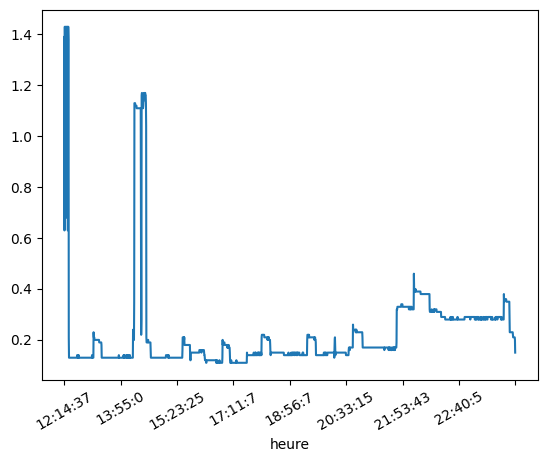

In [36]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [37]:
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:15:35.564141,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:15:57.422141,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:16:19.423141,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:16:41.351141,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:17:03.242141,21/08/23
...,...,...,...,...,...,...,...
1935233,17261,0.21,17.261,208.562656,47441785616,2025-02-20 23:31:39.246141,20/02/25
1935234,17292,0.21,17.292,208.188758,47441802908,2025-02-20 23:31:56.538141,20/02/25
1935235,17290,0.21,17.290,208.212840,47441820198,2025-02-20 23:32:13.828141,20/02/25
1935236,18006,0.20,18.006,199.933356,47441838204,2025-02-20 23:32:31.834141,20/02/25


In [38]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0:0:18,20281,0.18,20.281,177.506040,47357104441,2025-02-20 00:00:18.071141,20/02/25
0:0:38,20410,0.18,20.410,176.384125,47357124851,2025-02-20 00:00:38.481141,20/02/25
0:0:57,19013,0.19,19.013,189.344133,47357143864,2025-02-20 00:00:57.494141,20/02/25
0:1:17,19531,0.18,19.531,184.322359,47357163395,2025-02-20 00:01:17.025141,20/02/25
0:1:36,19573,0.18,19.573,183.926838,47357182968,2025-02-20 00:01:36.598141,20/02/25
...,...,...,...,...,...,...,...
23:31:39,17261,0.21,17.261,208.562656,47441785616,2025-02-20 23:31:39.246141,20/02/25
23:31:56,17292,0.21,17.292,208.188758,47441802908,2025-02-20 23:31:56.538141,20/02/25
23:32:13,17290,0.21,17.290,208.212840,47441820198,2025-02-20 23:32:13.828141,20/02/25


In [39]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
kwh_byhour = df_byhour['kWh']



Max : 22/01/25 4.787
Min : 31/01/25 2.817


,Interval,kWh,sec,Wh,cumul(ms),dates,days,heure
1931400,20281,0.18,20.281,177.506040,47357104441,2025-02-20 00:00:18.071141,20/02/25,0:0:18
1931401,20410,0.18,20.410,176.384125,47357124851,2025-02-20 00:00:38.481141,20/02/25,0:0:38
1931402,19013,0.19,19.013,189.344133,47357143864,2025-02-20 00:00:57.494141,20/02/25,0:0:57
1931403,19531,0.18,19.531,184.322359,47357163395,2025-02-20 00:01:17.025141,20/02/25,0:1:17
1931404,19573,0.18,19.573,183.926838,47357182968,2025-02-20 00:01:36.598141,20/02/25,0:1:36
...,...,...,...,...,...,...,...,...
1935233,17261,0.21,17.261,208.562656,47441785616,2025-02-20 23:31:39.246141,20/02/25,23:31:39
1935234,17292,0.21,17.292,208.188758,47441802908,2025-02-20 23:31:56.538141,20/02/25,23:31:56
1935235,17290,0.21,17.290,208.212840,47441820198,2025-02-20 23:32:13.828141,20/02/25,23:32:13
1935236,18006,0.20,18.006,199.933356,47441838204,2025-02-20 23:32:31.834141,20/02/25,23:32:31


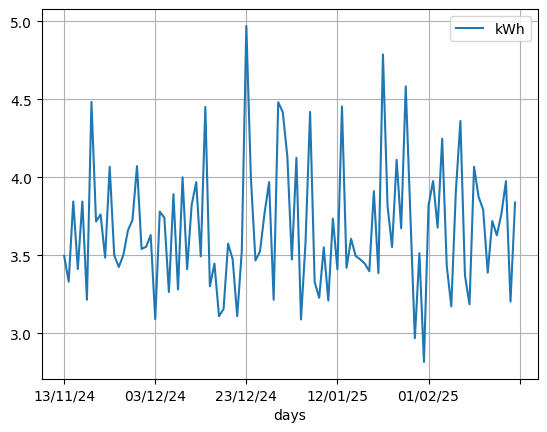

In [40]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates
df.dates.dt.time

# save data
df_grp.to_csv('df_grp.csv')
df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp.info()
df_grp.mean()
#df_grp.head()
df_grp.tail(14)
df_grp.tail(100).mean()
df_grp.tail(100).plot()
plt.grid()
# max min during last month
#print(df_grp.iloc[-31:-1])
df_grp.iloc[-31:-1].describe()

month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))
conso_day


2025-02-20 00:00:18.071141	2025-02-20 08:57:01.277141	8h 56m 43s 	1000
2025-02-20 08:57:01.277141	2025-02-20 13:14:54.176141	4h 17m 52s 	2000
2025-02-20 13:14:54.176141	2025-02-20 19:57:38.659141	6h 42m 44s 	3000
2025-02-20 19:57:38.659141	2025-02-20 23:32:56.296141	3h 35m 17s 	838
<class 'pandas.core.frame.DataFrame'>
Index: 3838 entries, 1931400 to 1935237
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3838 non-null   int64         
 1   kWh        3838 non-null   float64       
 2   sec        3838 non-null   float64       
 3   Wh         3838 non-null   float64       
 4   cumul(ms)  3838 non-null   int64         
 5   dates      3838 non-null   datetime64[ns]
 6   days       3838 non-null   object        
 7   heure      3838 non-null   object        
 8   hours      3838 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 299.8+ KB


('20/02/25', <Axes: xlabel='hours'>)

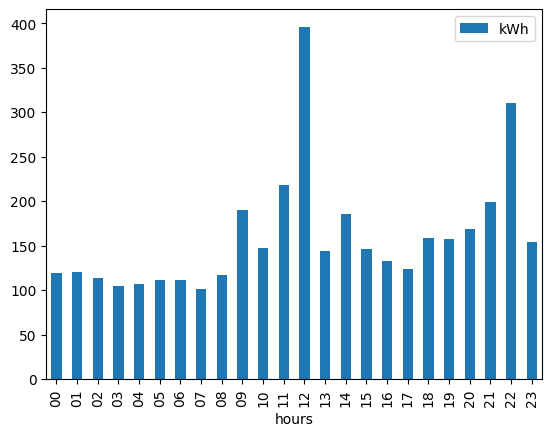

In [41]:

tranches = len(df)//1000
tranches+1
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()

conso_hours
# group conso of the day by hour
groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
list(groupedbyhour)
day, groupedbyhour.count().plot.bar()

In [42]:
df_grp

,kWh
days,
21/08/23,0.556
22/08/23,3.701
23/08/23,4.226
24/08/23,3.687
25/08/23,3.951
...,...
16/02/25,3.628
17/02/25,3.765
18/02/25,3.975


In [43]:
# select number of days to display
span = 30
#df_grp.tail(span)


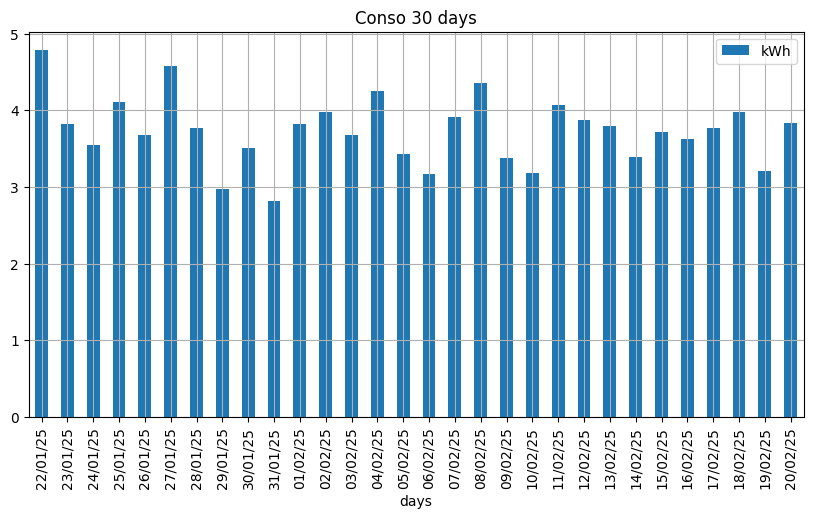

In [44]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


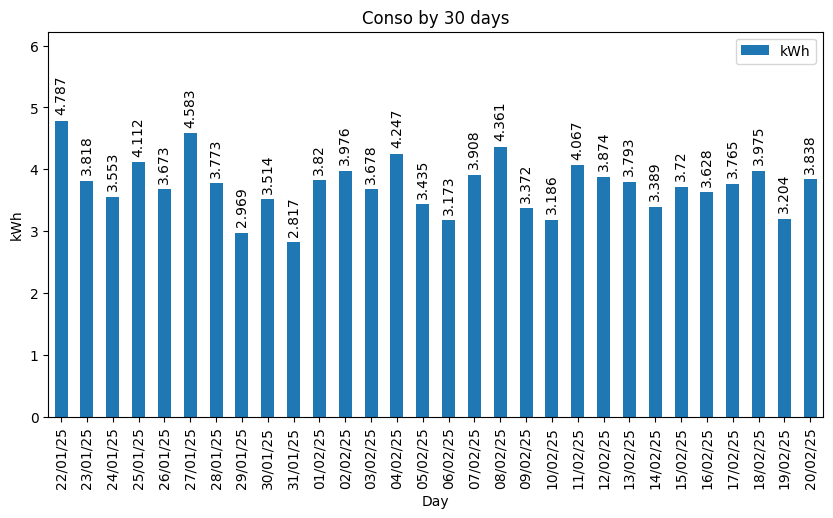

In [45]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [46]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
22/01/25    4.787
23/01/25    3.818
24/01/25    3.553
25/01/25    4.112
26/01/25    3.673
27/01/25    4.583
28/01/25    3.773
29/01/25    2.969
30/01/25    3.514
31/01/25    2.817
01/02/25    3.820
02/02/25    3.976
03/02/25    3.678
04/02/25    4.247
05/02/25    3.435
06/02/25    3.173
07/02/25    3.908
08/02/25    4.361
09/02/25    3.372
10/02/25    3.186
11/02/25    4.067
12/02/25    3.874
13/02/25    3.793
14/02/25    3.389
15/02/25    3.720
16/02/25    3.628
17/02/25    3.765
18/02/25    3.975
19/02/25    3.204
20/02/25    3.838
Name: kWh, dtype: float64

In [47]:
x_labels=df_grp.tail(span).index
x_labels

Index(['22/01/25', '23/01/25', '24/01/25', '25/01/25', '26/01/25', '27/01/25',
       '28/01/25', '29/01/25', '30/01/25', '31/01/25', '01/02/25', '02/02/25',
       '03/02/25', '04/02/25', '05/02/25', '06/02/25', '07/02/25', '08/02/25',
       '09/02/25', '10/02/25', '11/02/25', '12/02/25', '13/02/25', '14/02/25',
       '15/02/25', '16/02/25', '17/02/25', '18/02/25', '19/02/25', '20/02/25'],
      dtype='object', name='days')

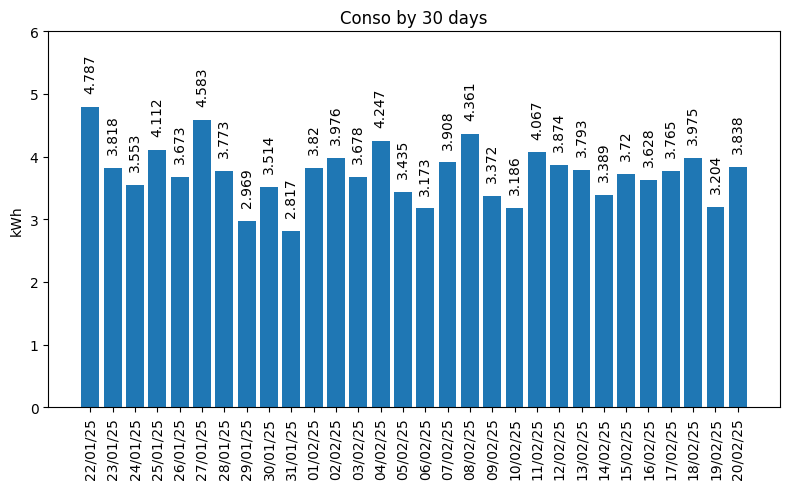

In [48]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [49]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

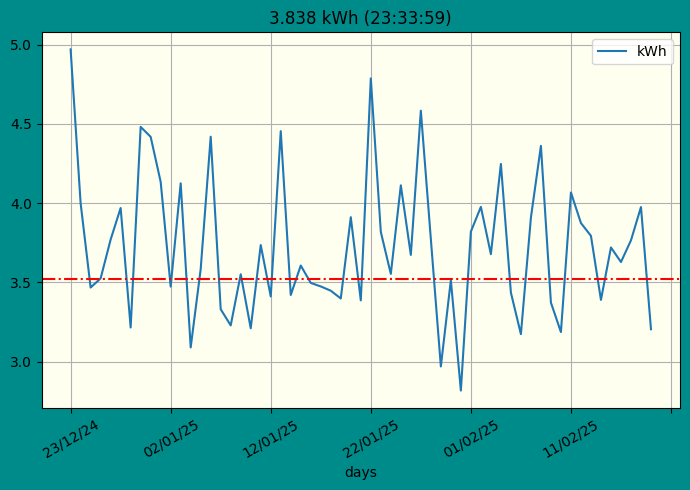

In [50]:
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

# 2 last months
df_grp.iloc[-60:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

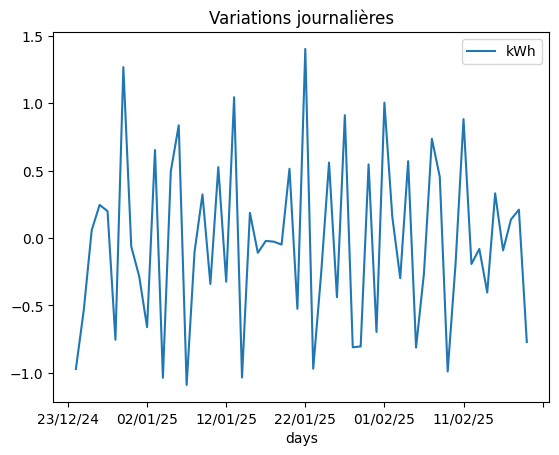

In [51]:
# variations journalières
df_grp.iloc[-60:-1].diff().plot()
plt.title('Variations journalières')

# Data from 21/08/23

In [52]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:15:35.564141,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:15:57.422141,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:16:19.423141,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:16:41.351141,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:17:03.242141,21/08/23,21
...,...,...,...,...,...,...,...,...
1935233,17261,0.21,17.261,208.562656,47441785616,2025-02-20 23:31:39.246141,20/02/25,23
1935234,17292,0.21,17.292,208.188758,47441802908,2025-02-20 23:31:56.538141,20/02/25,23
1935235,17290,0.21,17.290,208.212840,47441820198,2025-02-20 23:32:13.828141,20/02/25,23
1935236,18006,0.20,18.006,199.933356,47441838204,2025-02-20 23:32:31.834141,20/02/25,23


In [53]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [54]:
import pandas as pd
df = pd.read_csv(r'C:\Users\jean\Downloads\only-bh-extreme-events-satellite.csv'
                  ,index_col=[0,1,2,3,4]
                  ,header=[0,1,2,3]
                  ,skipinitialspace=True
                  #,tupleize_cols=True
                ) 

df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index.names

FrozenList(['wsid', 'lat', 'lon', 'start', 'prcp_24'])

In [55]:
index=df.columns.levels[0]
index

Index(['al', 'asn', 'cc', 'chnk', 'ci', 'ciwc', 'clwc', 'd', 'd2m', 'hcc',
       'istl1', 'istl2', 'istl3', 'istl4', 'lcc', 'lsrh', 'mcc', 'msl', 'o3',
       'p53.162', 'p54.162', 'p55.162', 'p56.162', 'p57.162', 'p58.162',
       'p59.162', 'p60.162', 'p61.162', 'p62.162', 'p63.162', 'p64.162',
       'p65.162', 'p66.162', 'p67.162', 'p68.162', 'p69.162', 'p70.162',
       'p71.162', 'p72.162', 'p73.162', 'p74.162', 'p75.162', 'p76.162',
       'p77.162', 'p78.162', 'p79.162', 'p80.162', 'p81.162', 'p82.162',
       'p83.162', 'p84.162', 'p85.162', 'p86.162', 'p87.162', 'p88.162',
       'p89.162', 'p90.162', 'p91.162', 'p92.162', 'pv', 'q', 'r', 'rsn', 'sd',
       'skt', 'sp', 'sr', 'src', 'sst', 'stl1', 'stl2', 'stl3', 'stl4',
       'swvl1', 'swvl2', 'swvl3', 'swvl4', 't', 't2m', 'tcc', 'tco3', 'tcw',
       'tcwv', 'tsn', 'u', 'u10', 'v', 'v10', 'vo', 'w', 'z'],
      dtype='object')

In [56]:
df_des = pd.DataFrame(
                            index=df.columns.levels[0],
                            columns=['count','mean','std','min','25','50','75','max']
                         )
df_des

,count,mean,std,min,25,50,75,max
al,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chnk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ci,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
v,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
v10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,556
22/08/23,3701
23/08/23,4226
24/08/23,3687
25/08/23,3951
...,...
16/02/25,3628
17/02/25,3765
18/02/25,3975


In [58]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:15:35.564141,21/08/23,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:15:57.422141,21/08/23,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:16:19.423141,21/08/23,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:16:41.351141,21/08/23,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:17:03.242141,21/08/23,21
...,...,...,...,...,...,...,...,...
1935233,17261,0.21,17.261,208.562656,47441785616,2025-02-20 23:31:39.246141,20/02/25,23
1935234,17292,0.21,17.292,208.188758,47441802908,2025-02-20 23:31:56.538141,20/02/25,23
1935235,17290,0.21,17.290,208.212840,47441820198,2025-02-20 23:32:13.828141,20/02/25,23
1935236,18006,0.20,18.006,199.933356,47441838204,2025-02-20 23:32:31.834141,20/02/25,23


In [59]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
20/02/25 23    1935233  20/02/25    23  0.21
               1935234  20/02/25    23  0.21
               1935235  20/02/25    23  0.21
               1935236  20/02/25    23  0.20
               1935237  20/02/25    23  0.15

[1935238 rows x 3 columns]

In [60]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [61]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [62]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,556,556
22/08/23,3701,3701
23/08/23,4226,4226
24/08/23,3687,3687
25/08/23,3951,3951
...,...,...
16/02/25,3628,3628
17/02/25,3765,3765
18/02/25,3975,3975


In [63]:
grp_by_day['kWh'].cumsum()

days
21/08/23        556
22/08/23       4257
23/08/23       8483
24/08/23      12170
25/08/23      16121
             ...   
16/02/25    1920456
17/02/25    1924221
18/02/25    1928196
19/02/25    1931400
20/02/25    1935238
Name: kWh, Length: 550, dtype: int64

In [64]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21     137
         22     285
         23     134
22/08/23 00     129
         01     131
...             ...
20/02/25 19     157
         20     169
         21     199
         22     311
         23     154

[13179 rows x 1 columns]

In [65]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21           137
          22           422
          23           556
22/08/23  00           685
          01           816
                    ...   
20/02/25  19       1934405
          20       1934574
          21       1934773
          22       1935084
          23       1935238
Name: kWh, Length: 13179, dtype: int64

In [66]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21     137     137    NaN
         22     285     422  148.0
         23     134     556 -151.0
22/08/23 00     129     129    NaN
         01     131     260    2.0
...             ...     ...    ...
20/02/25 19     157    3005   -2.0
         20     169    3174   12.0
         21     199    3373   30.0
         22     311    3684  112.0
         23     154    3838 -157.0

[13179 rows x 3 columns]

In [67]:
today, grp_by_dayhours.loc[today]

('20/02/25',
        kWh  cumsum   diff
 hours                    
 00     119     119    NaN
 01     120     239    1.0
 02     114     353   -6.0
 03     105     458   -9.0
 04     107     565    2.0
 05     111     676    4.0
 06     111     787    0.0
 07     101     888  -10.0
 08     117    1005   16.0
 09     190    1195   73.0
 10     147    1342  -43.0
 11     218    1560   71.0
 12     396    1956  178.0
 13     144    2100 -252.0
 14     186    2286   42.0
 15     146    2432  -40.0
 16     133    2565  -13.0
 17     124    2689   -9.0
 18     159    2848   35.0
 19     157    3005   -2.0
 20     169    3174   12.0
 21     199    3373   30.0
 22     311    3684  112.0
 23     154    3838 -157.0)

Text(0.5, 1.0, 'Cumul journalier')

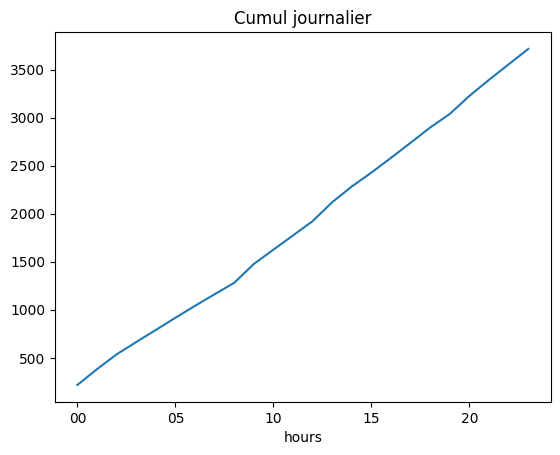

In [68]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

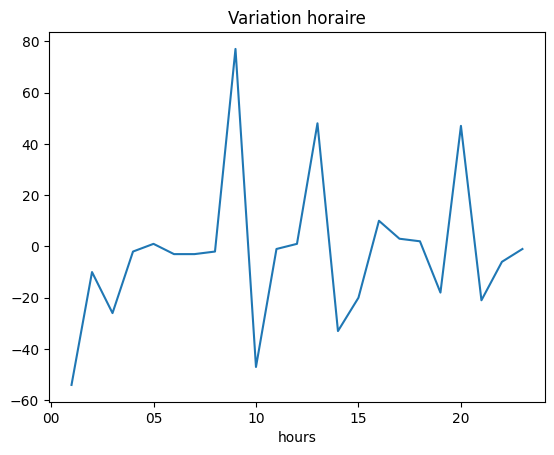

In [69]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [70]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

550

In [71]:
df_grp.tail(n)['kWh'].describe()


count    550.000000
mean       3.518615
std        0.667508
min        0.556000
25%        3.354500
50%        3.628000
75%        3.877000
max        5.036000
Name: kWh, dtype: float64

In [72]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '550 days')

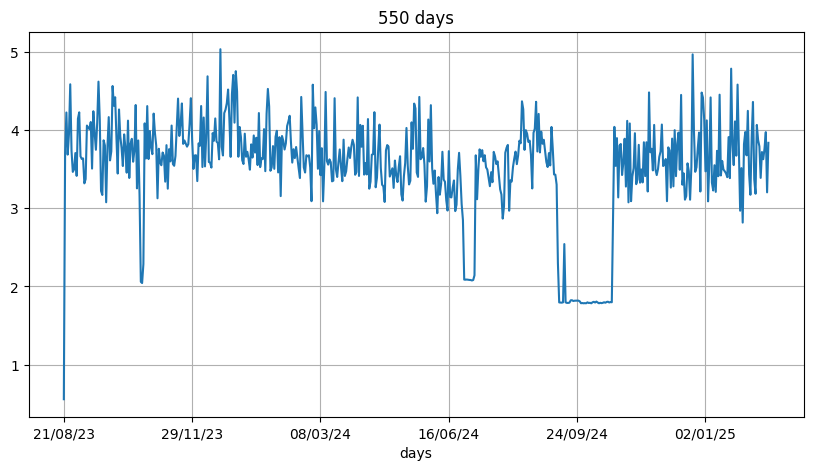

In [73]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

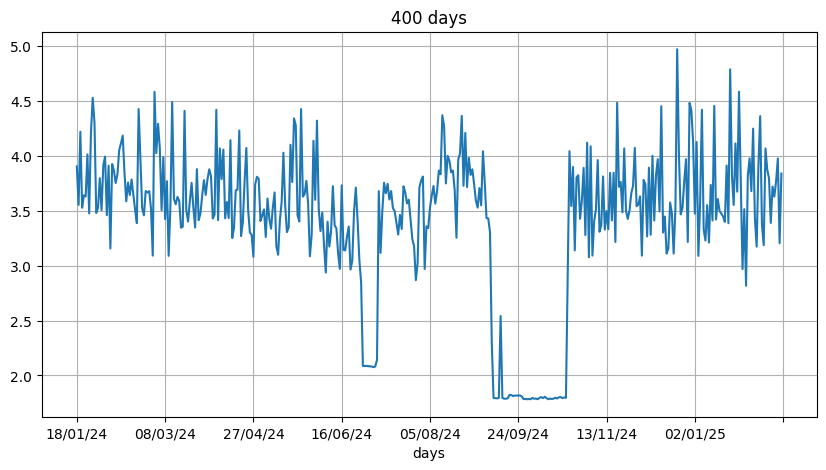

In [74]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [75]:
df_grp['kWh']

days
21/08/23    0.556
22/08/23    3.701
23/08/23    4.226
24/08/23    3.687
25/08/23    3.951
            ...  
16/02/25    3.628
17/02/25    3.765
18/02/25    3.975
19/02/25    3.204
20/02/25    3.838
Name: kWh, Length: 550, dtype: float64

In [76]:
df_grp.describe()

,kWh
count,550.000000
mean,3.518615
std,0.667508
min,0.556000
25%,3.354500
50%,3.628000
75%,3.877000
max,5.036000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

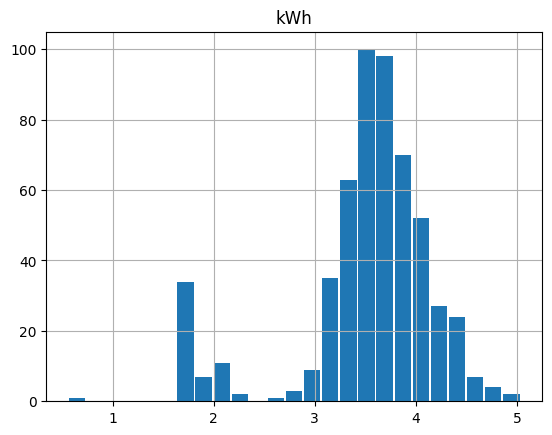

In [77]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [78]:
df_grp.tail(span)['kWh']

days
18/01/24    3.903
19/01/24    3.553
20/01/24    4.219
21/01/24    3.527
22/01/24    3.640
            ...  
16/02/25    3.628
17/02/25    3.765
18/02/25    3.975
19/02/25    3.204
20/02/25    3.838
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [79]:
day

'20/02/25'

In [80]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,119,119,NaN
01,120,239,1.0
02,114,353,-6.0
03,105,458,-9.0
04,107,565,2.0
05,111,676,4.0
06,111,787,0.0
07,101,888,-10.0
08,117,1005,16.0


In [81]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


24

In [82]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 25)

In [83]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [84]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.])

In [85]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
23    24.0
Name: days, dtype: float64

In [86]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [87]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 00 to 23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     24 non-null     int64  
 1   cumsum  24 non-null     int64  
 2   diff    23 non-null     float64
 3   days    24 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 960.0+ bytes


In [88]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
22    23.0
23    24.0
Name: days, dtype: float64

In [89]:
day

'20/02/25'

In [90]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,119,119,NaN,1.0
01,120,239,1.0,2.0
02,114,353,-6.0,3.0
03,105,458,-9.0,4.0
04,107,565,2.0,5.0
05,111,676,4.0,6.0
06,111,787,0.0,7.0
07,101,888,-10.0,8.0
08,117,1005,16.0,9.0


Text(0.5, 1.0, '20/02/25')

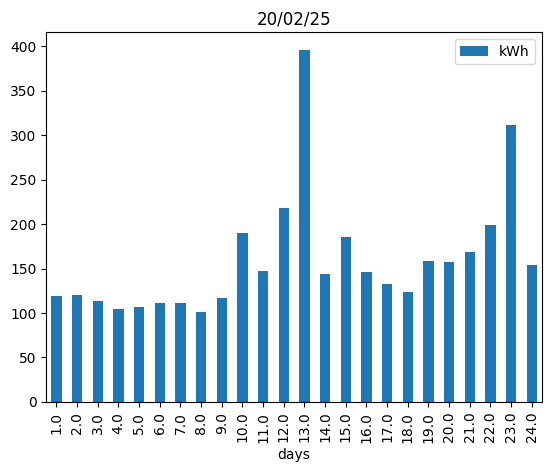

In [91]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [92]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object', name='hours')

# Conso du jour


In [93]:
groupedbyhour.count()

,kWh
hours,
00,119
01,120
02,114
03,105
04,107
05,111
06,111
07,101
08,117


In [94]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    155
01    161
02    166
03    153
04    169
05    159
06    154
07    141
08    115
09    130
10    131
11    114
12    130
13    115
14    132
15    204
16    139
17    157
18    987
19    208
20    279
21    301
22    313
23    323
Name: kWh, dtype: int64

In [95]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

367.87

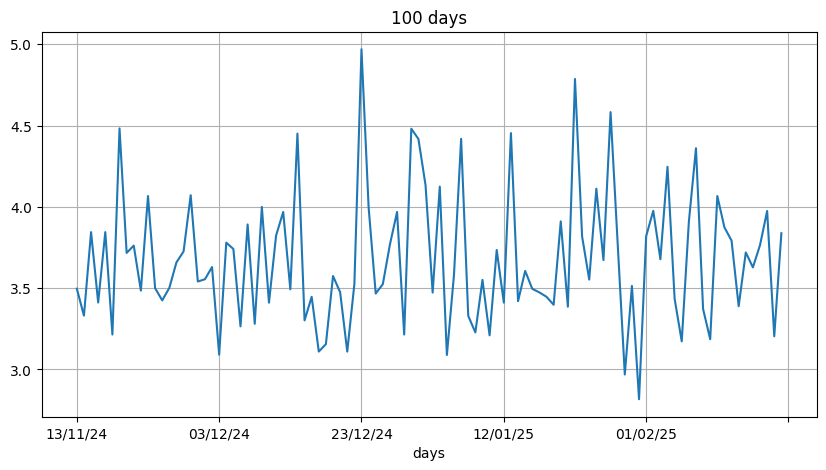

In [96]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

In [97]:
df_grp.tail(1)

,kWh
days,
20/02/25,3.838


In [98]:
span = 1
#df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
#plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])

3.838

In [99]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

173.57209515571594


# Today

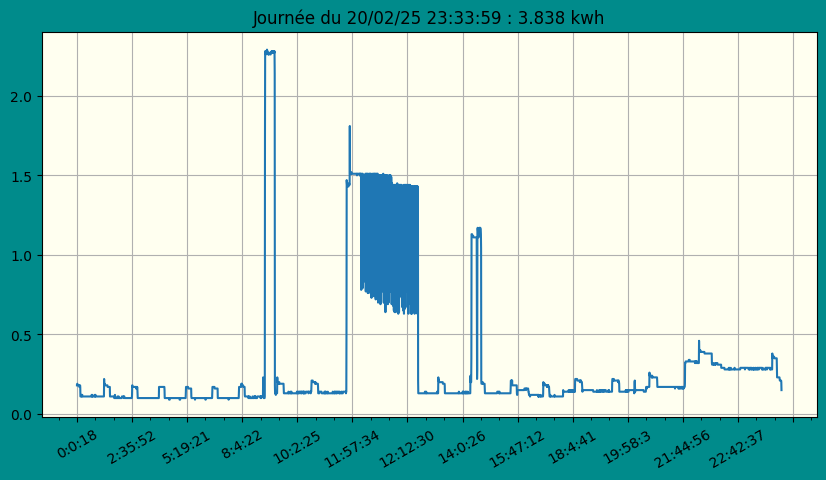

In [100]:
show(today,bgcolor='ivory')

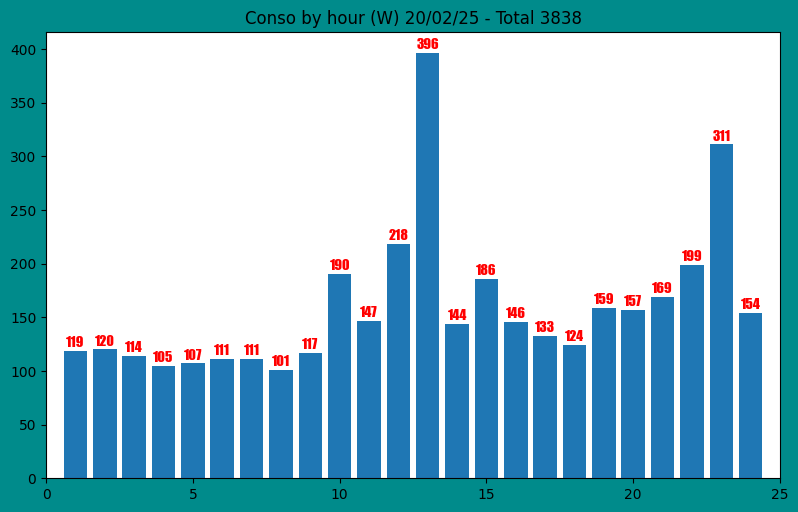

In [101]:
conso_by_hour(today)

In [102]:
day = '16/01/25'

('16/01/25', None)

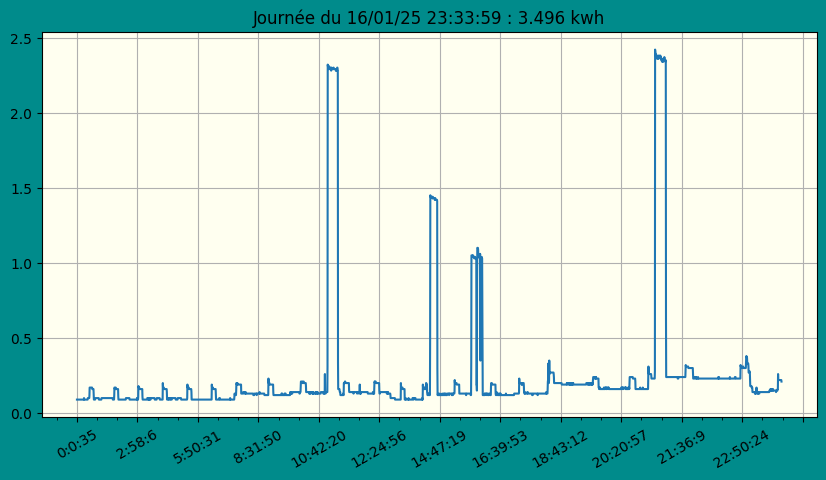

In [103]:
day, show(day,bgcolor='ivory')

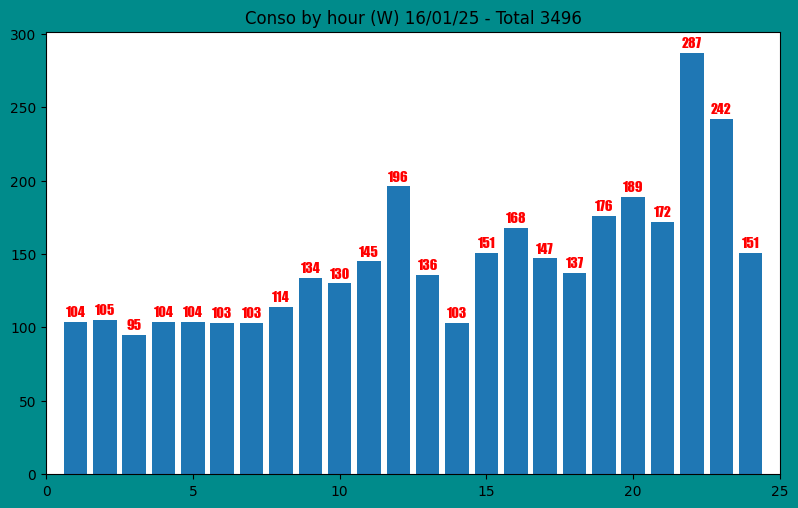

In [104]:
conso_by_hour(day)

In [105]:
maxday

'21/12/23'

('21/12/23', None)

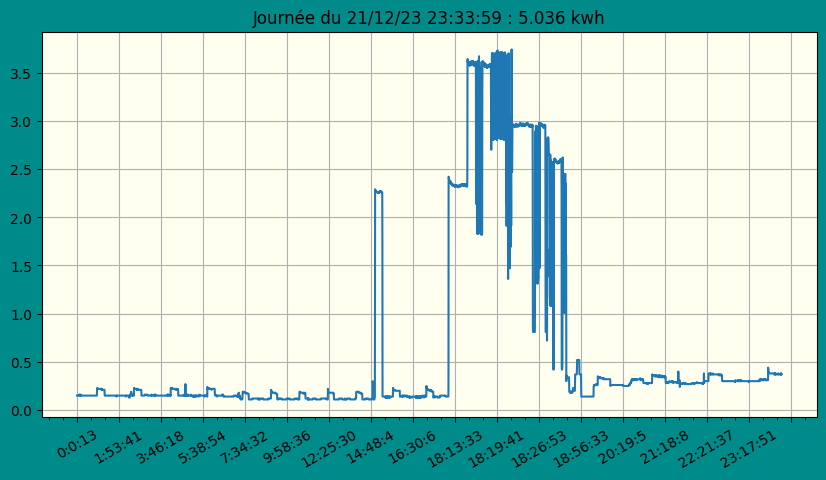

In [106]:
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')

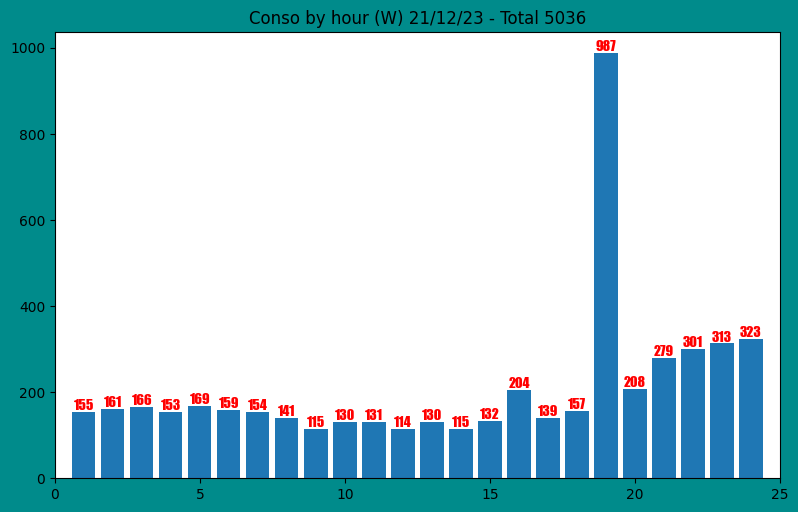

In [107]:
conso_by_hour(day)

In [108]:
sum(data)

5036

In [109]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,119,119,NaN,1.0
01,120,239,1.0,2.0
02,114,353,-6.0,3.0
03,105,458,-9.0,4.0
04,107,565,2.0,5.0
05,111,676,4.0,6.0
06,111,787,0.0,7.0
07,101,888,-10.0,8.0
08,117,1005,16.0,9.0


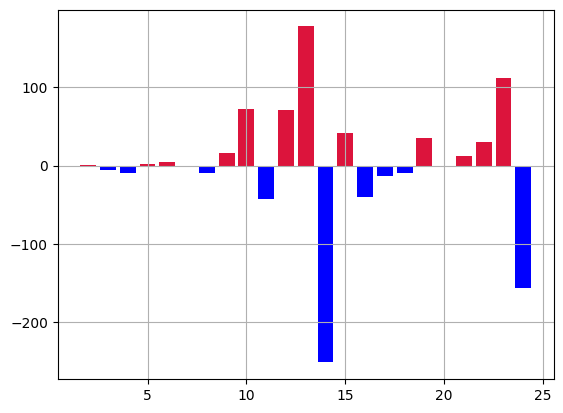

In [110]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [111]:
data

hours
00    155
01    161
02    166
03    153
04    169
05    159
06    154
07    141
08    115
09    130
10    131
11    114
12    130
13    115
14    132
15    204
16    139
17    157
18    987
19    208
20    279
21    301
22    313
23    323
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

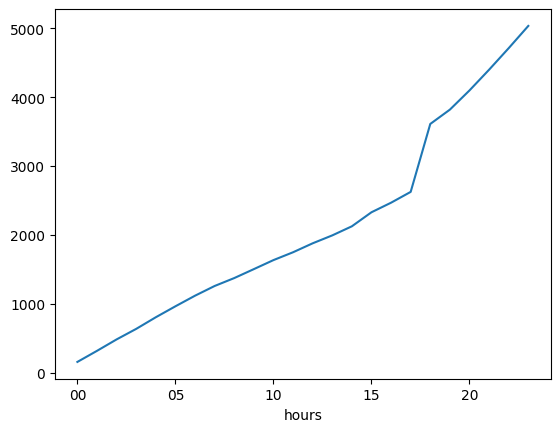

In [112]:
data.cumsum().plot()


<Axes: xlabel='hours'>

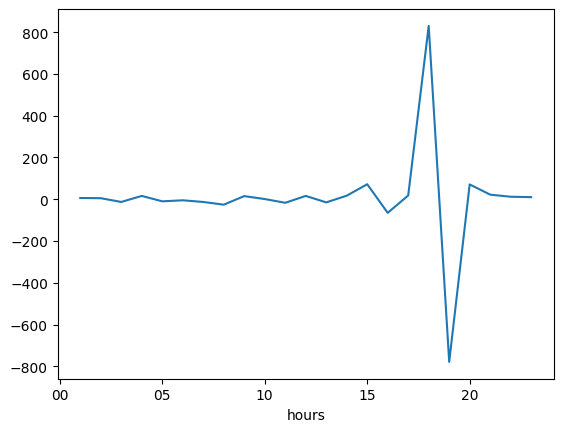

In [113]:
# evolution par heure
data.diff().plot()

In [114]:
data.diff().describe()

count     23.000000
mean       7.304348
std      244.276005
min     -779.000000
25%      -13.000000
50%        6.000000
75%       16.500000
max      830.000000
Name: kWh, dtype: float64

<Axes: >

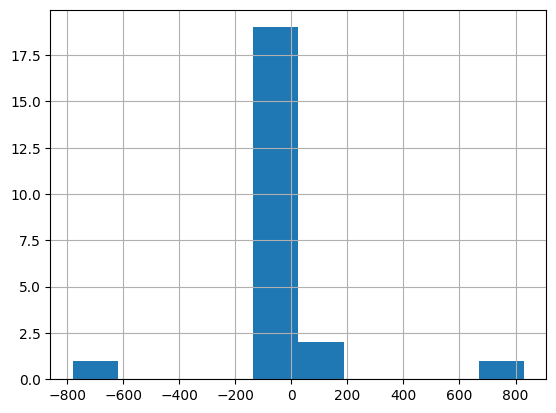

In [115]:
data.diff().hist()

# Test sauvegarde

In [116]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_fernet.ipynb',
 'csv_readwrite

In [117]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [118]:
#conso_byhour(day)

In [119]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


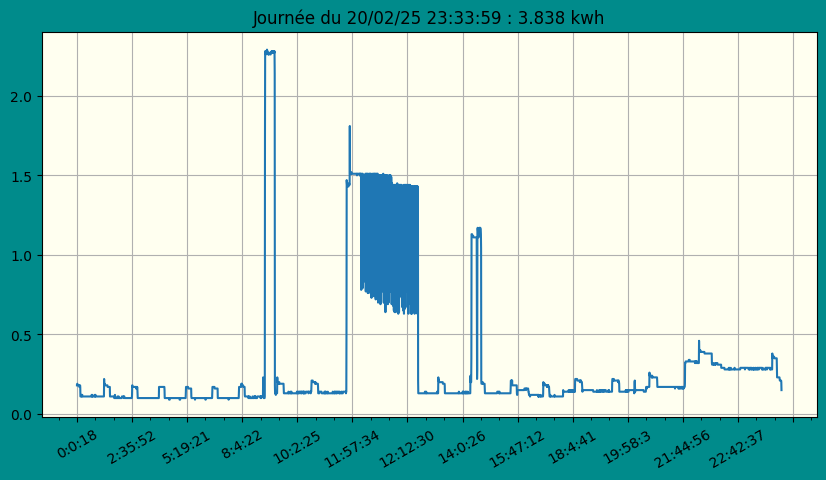

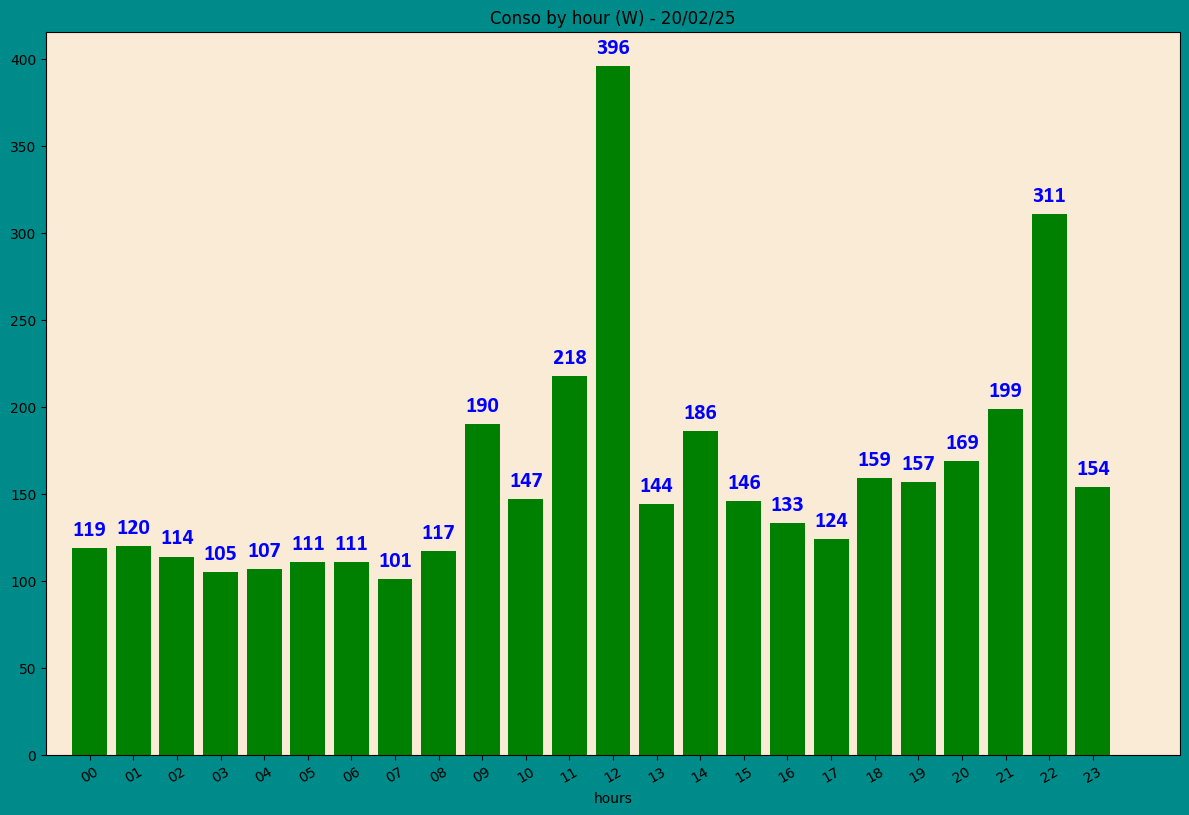

In [120]:
day = '27/10/24'
day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [121]:
month.describe()


count    30.000000
mean      3.718533
std       0.447272
min       2.817000
25%       3.400500
50%       3.742500
75%       3.958250
max       4.787000
Name: kWh, dtype: float64

<Axes: >

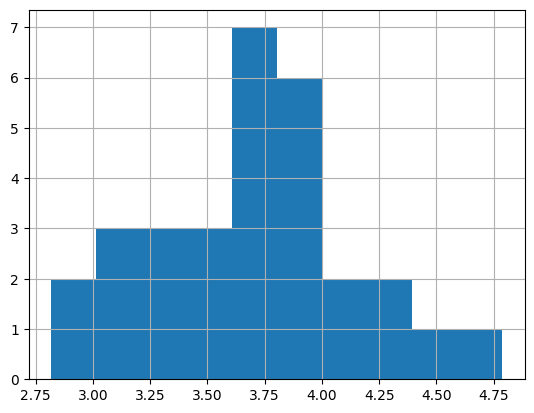

In [122]:
month.hist()

<Axes: xlabel='days'>

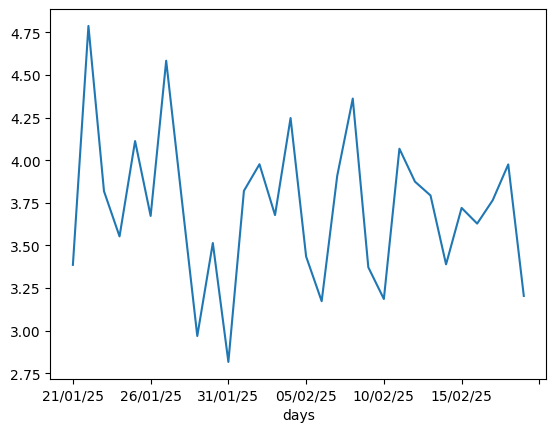

In [123]:
month.plot()

In [124]:
# date with max conso in 1 month
month.idxmax()

'22/01/25'

In [125]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

'22/01/25'

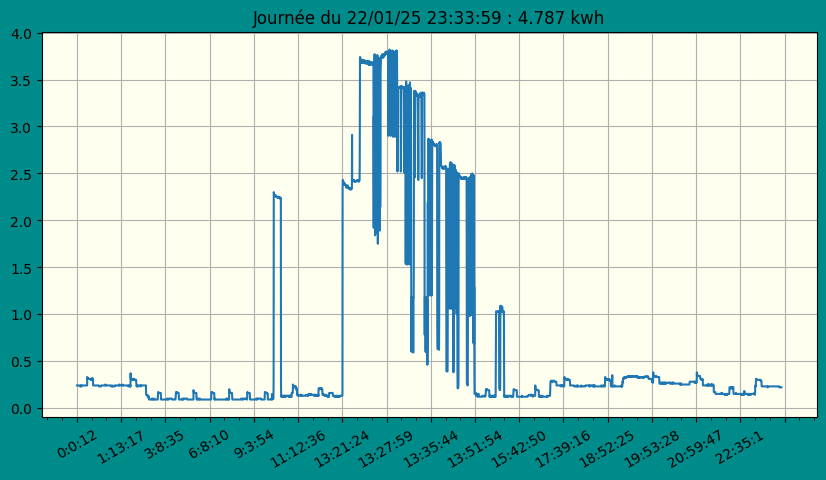

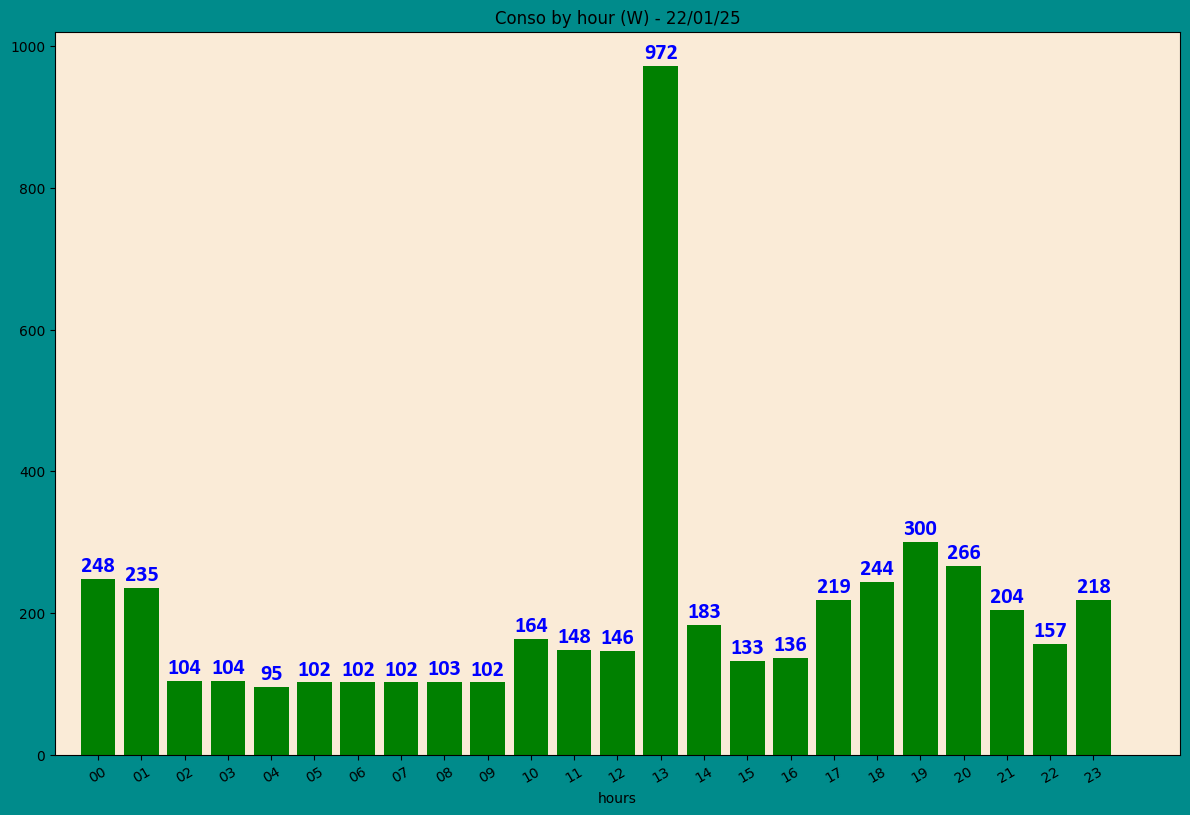

In [126]:
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [127]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21     137     137    NaN   NaN
         22     285     422  148.0   NaN
         23     134     556 -151.0   NaN
22/08/23 00     129     129    NaN   NaN
         01     131     260    2.0   NaN
...             ...     ...    ...   ...
20/02/25 19     157    3005   -2.0  20.0
         20     169    3174   12.0  21.0
         21     199    3373   30.0  22.0
         22     311    3684  112.0  23.0
         23     154    3838 -157.0  24.0

[13179 rows x 4 columns]

In [128]:
grp_by_dayhours.loc[month.idxmax()]

,kWh,cumsum,diff,days
hours,,,,
00,248,248,NaN,NaN
01,235,483,-13.0,NaN
02,104,587,-131.0,NaN
03,104,691,0.0,NaN
04,95,786,-9.0,NaN
05,102,888,7.0,NaN
06,102,990,0.0,NaN
07,102,1092,0.0,NaN
08,103,1195,1.0,NaN


In [129]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

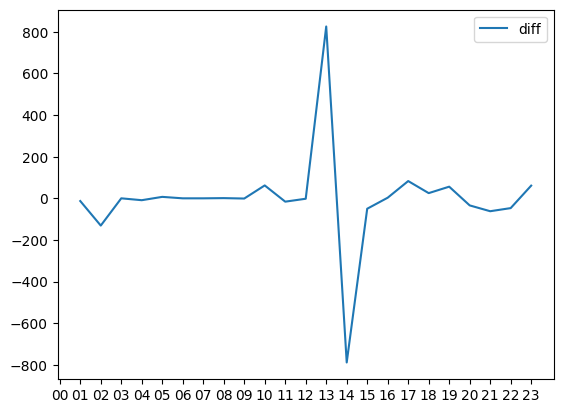

In [130]:
# diff
plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
plt.legend()

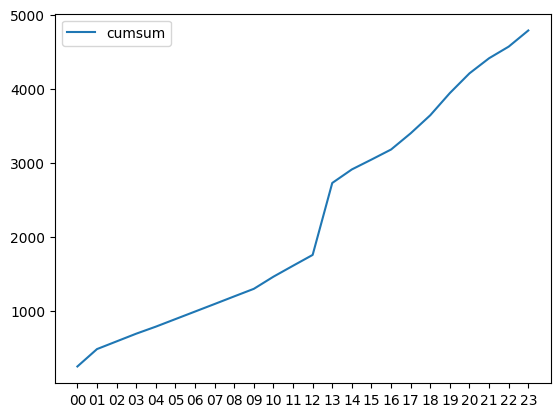

In [131]:
# cumsum
plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
plt.legend()

In [132]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB